# T-Learner
* Meta-Learnerの手法の一つ
* 機械学習手法はどのようなものを使ってもよい(以下ではLightGBMを使う)

In [7]:
import random
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt
import scipy.stats
from scipy.special import expit
import pandas as pd

#LightGBMのインポート
import lightgbm as lgbm

## データの用意

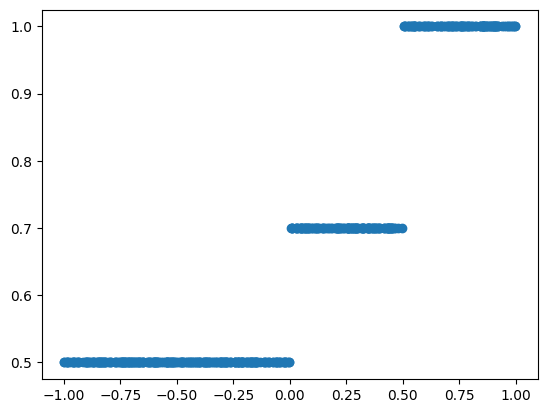

In [3]:
# データ数
num_data = 500

# 部下育成への熱心さ
x = np.random.uniform(low=-1, high=1, size=num_data)  # -1から1の一様乱数

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
e_z = randn(num_data)  # ノイズの生成
z_prob = expit(-5.0*x+5*e_z)
Z = np.array([])

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
for i in range(num_data):
    Z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    Z = np.append(Z, Z_i)

# 介入効果の非線形性：部下育成の熱心さxの値に応じて段階的に変化
t = np.zeros(num_data)
for i in range(num_data):
    if x[i] < 0:
        t[i] = 0.5
    elif x[i] >= 0 and x[i] < 0.5:
        t[i] = 0.7
    elif x[i] >= 0.5:
        t[i] = 1.0

e_y = randn(num_data)
Y = 2.0 + t*Z + 0.3*x + 0.1*e_y 

# 介入効果を図で確認
plt.scatter(x, t, label="treatment-effect")

In [4]:
df = pd.DataFrame({'x': x,
                   'Z': Z,
                   't': t,
                   'Y': Y,
                   })

df.head()

,x,Z,t,Y
0,0.923260,1.0,1.0,3.328991
1,-0.735001,1.0,0.5,2.057692
2,-0.684832,1.0,0.5,2.242923
3,-0.744887,1.0,0.5,2.425685
4,0.295782,1.0,0.7,2.854423


## T-Learner

In [ ]:
params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse'
}


categorical_features = []



# 介入を受けていない集団のモデル
df_0 = df[df.Z == 0.0]
x_train_0 = df_0[["x"]]
y_train_0 = df_0[["Y"]]

#LightGBM用の訓練データセットを作成
lgb_train_0 = lgbm.Dataset(x_train_0, y_train_0, categorical_feature=categorical_features, free_raw_data=False)


model_0 = lgbm.train(params = params,
                        train_set = lgb_train_0)




# 介入を受けた集団
df_1 = df[df.Z == 1.0]
x_train_1 = df_1[["x"]]
y_train_1 = df_1[["Y"]]
#LightGBM用の訓練データセットを作成
lgb_train_1 = lgbm.Dataset(x_train_1,y_train_1,categorical_feature=categorical_features,free_raw_data=False)

model_1 = lgbm.train(params = params,
                        train_set = lgb_train_1)

## ATEを求める

In [19]:
# ATEを求める
mu_0 = model_0.predict(df[["x"]])
mu_1 = model_1.predict(df[["x"]])

ATE = (mu_1-mu_0).mean()
print("ATE：", ATE)

ATE： 0.6460403387928113


## ATT,ATUを求める

In [23]:
# 処置群における平均処置効果ATT
ATT = df_1["Y"] - model_0.predict(df_1[["x"]],num_iteration=model_0.best_iteration)

# 対照群における平均処置効果ATU
ATU = model_1.predict(df_0[["x"]],num_iteration=model_1.best_iteration) - df_0["Y"]

print("ATT：", ATT.mean())
print("ATU：", ATU.mean())

ATT： 0.5794372494397041
ATU： 0.7126434345141379


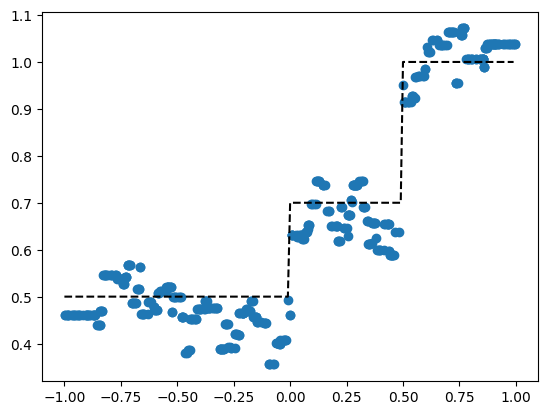

In [21]:
# 推定された処置効果を各人ごとに求めます
t_estimated = model_1.predict(
    df[["x"]]) - model_0.predict(df[["x"]])
plt.scatter(df[["x"]], t_estimated,
            label="estimated_treatment-effect")

# 正解のグラフを作成
x_index = np.arange(-1, 1, 0.01)
t_ans = np.zeros(len(x_index))
for i in range(len(x_index)):
    if x_index[i] < 0:
        t_ans[i] = 0.5
    elif x_index[i] >= 0 and x_index[i] < 0.5:
        t_ans[i] = 0.7
    elif x_index[i] >= 0.5:
        t_ans[i] = 1.0


# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')